# **4. Neural Network for Multiclass Classification & Optimization Strategy**
---

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

import copy
import time

import torch

We're going to build a Neural Network for MultiClass Classification using `PyTorch` & Optimization Strategy

In [2]:
# For pre-activation layer (including linear activation function)
class Linear:
    """Layer of linear operation"""
    def __init__(self, feature_in, feature_out, bias=True):
        """Generate model parameter in linear layer"""
        # Generate random weight & biases
        self.weight = torch.rand((feature_in, feature_out)).double()
        if bias:
            self.bias = torch.zeros(feature_out).double()
        else:
            self.bias = None

    def __call__(self, x):
        """Return the weighted sum between model param & imputed value"""
        weighted_sum = x @ self.weight
        if self.bias is not None:
            self.out = weighted_sum + self.bias
        else:
            self.out = weighted_sum

        return self.out

    def parameters(self):
        """Collect all parameters in a list"""
        return [self.weight] + ([] if self.bias is None else [self.bias])

# For sigmoid layer
class Sigmoid:
    """Sigmoid operation"""
    def __call__(self, x):
        self.out = torch.sigmoid(x)
        return self.out

    def parameters(self):
        # no parameter included
        return []

# For ReLU layer
class ReLU:
    """ReLU operation"""
    def __call__(self, x):
        self.out = torch.relu(x)
        return self.out

    def parameters(self):
        # no parameter included
        return []

# For TanH layer
class Tanh:
    """TanH operation"""
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        # no parameter included
        return []


In [3]:
# For building a sequential MLP
class Sequential:
    """Create a sequential procedures to build a neural network"""
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        x = copy.deepcopy(x)

        # Iterate on given layers
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [4]:
# Load the previous Loss functions
def mse_loss(input, target):
    """
    Mean squared error loss

    Parameters
    ----------
    input : torch.Tensor
        The predicted value

    target : torch.Tensor
        The ground truth
    """
    return torch.mean((target-input)**2)

def bce_loss(input, target):
    """
    Binary cross-entropy loss

    Parameters
    ----------
    input : torch.Tensor
        The predicted value (unnormalized logits)

    target : torch.Tensor
        The ground truth. Only 0 or 1
    """
    return -torch.mean(target*torch.log(input+1e-16) + (1-target)*torch.log(1-(input+1e-16)))


## **Task 1**
---

- For a multiclass classification, create a class to represent the softmax activation function called `Softmax`.
- Each class has
  - `__call__` method that return the activation function value.
  - `parameters` method that return the model parameters.

The Softmax function

$$
\text{softmax}(\mathbf{x})_{i}
=
\cfrac{e^{x_{i}}}
{\sum_{j=1}^{n} e^{x_{j}}}
$$

In [5]:
# Write your code in here
class Softmax:
    """Softmax operation"""
    def __call__(self, x):
        # From scratch
        #e_x = torch.exp(x)
        #s_x = e_x / torch.sum(e_x, axis=1).reshape(-1, 1)      # The softmax

        # with torch
        s_x = torch.softmax(input = x,
                            dim=1)

        self.out = s_x
        return self.out

    def parameters(self):
        # no parameter included
        return []


Let's test it!

In [6]:
# Say you want to create
# A neural network with
#  - 5 input
#  - 1 output layer (with 3 output)
torch.manual_seed(123)

# Create layer
layers = [
    Linear(feature_in=5, feature_out=3), Softmax()
]

# Create sequential model
mdl = Sequential(layers = layers)

print(mdl)

In [7]:
# Pred
xs = torch.tensor([[1., 2., 3., 4., 5.],
                   [4., 3., 1., 2., 2.]]).double()
ys = mdl(xs)

print('Layer object :', mdl)
print('Layer param  :\n', mdl.parameters())
print('Called param :', ys)

Layer object : <__main__.Sequential object at 0x7f32a0744460>
Layer param  :
 [tensor([[0.2961, 0.5166, 0.2517],
        [0.6886, 0.0740, 0.8665],
        [0.1366, 0.1025, 0.1841],
        [0.7264, 0.3153, 0.6871],
        [0.0756, 0.1966, 0.3164]], dtype=torch.float64), tensor([0., 0., 0.], dtype=torch.float64)]
Called param : tensor([[0.1786, 0.0208, 0.8006],
        [0.2901, 0.0600, 0.6499]], dtype=torch.float64)


Let's validate

In [8]:
# From the given weights
w = mdl.parameters()[0]
b = mdl.parameters()[1]

# Do the feed forward
pre_act = xs @ w + b
print('Pre activation value    :', pre_act)

# Get the activation value
e_x = torch.exp(pre_act)
soft_x = e_x / torch.sum(e_x, axis=1).reshape(-1, 1)
print('Activation value        :', soft_x)
print('Sum of activation value :', torch.sum(soft_x))


Pre activation value    : tensor([[5.3669, 3.2162, 6.8674],
        [4.9909, 3.4144, 5.7973]], dtype=torch.float64)
Activation value        : tensor([[0.1786, 0.0208, 0.8006],
        [0.2901, 0.0600, 0.6499]], dtype=torch.float64)
Sum of activation value : tensor(2., dtype=torch.float64)


Nice!

## **Task 2**
---

- Before training, we need to define the loss function.
- The softmax loss function is called by **cross-entropy loss**

$$
\mathcal{L} =
\cfrac{1}{n}
\sum_{i=1}^{n}
\sum_{j=1}^{h}
-y_{j}^{[i]}
\log \left (
a_{j}^{[i]}
\right )
$$

In [9]:
# Write your code here
def cross_entropy_loss(target, input):
    """
    Cross entropy loss

    Parameters
    ----------
    input : torch.Tensor
        The predicted value (normalized logits or softmax)

    target : torch.Tensor
        The ground truth (OHE). Only 0 or 1
    """
    return -torch.mean(torch.sum(target * torch.log(input+1e-16), axis=1))


Let's calculate it

In [10]:
# Define the ground thruth (OHE of the output)
y = torch.tensor([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
]).double()

# Define the predicted logits
ylogit = torch.tensor([
    [0.8, 0.4, 0.1],
    [0.4, 0.8, 0.2],
    [0.2, 0.4, 0.8]
]).double()

# Define the predicted softmax
ysoftmax = torch.exp(ylogit) / torch.sum(torch.exp(ylogit), axis=1).reshape(-1, 1)

# Calculate the cross-entropy loss
loss = cross_entropy_loss(input=ysoftmax, target=y)
loss

tensor(0.7892, dtype=torch.float64)

Now let's validate

In [11]:
import torch.nn.functional as F

loss_torch = F.cross_entropy(input=ylogit, target=y)
loss_torch

tensor(0.7892, dtype=torch.float64)

Nice! The result is similar despite different input

## **Task 3**
---

- Now, create a Neural Network to perform a multiclass classification

*Load Library*

In [12]:
# Load library
from sklearn.datasets import load_iris

*Prepare data*

In [13]:
# Load data
X, y = load_iris(return_X_y=True)

In [14]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test,
                                                    test_size = 0.5,
                                                    random_state = 42)

X_train.shape, X_valid.shape, X_test.shape

((120, 4), (15, 4), (15, 4))

In [15]:
from sklearn.preprocessing import StandardScaler

# Fit a scaler
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [16]:
# Transform data with scaler
X_train_clean = scaler.transform(X_train)
X_valid_clean = scaler.transform(X_valid)
X_test_clean = scaler.transform(X_test)

*Now, let's OHE the y data*

In [17]:
from sklearn.preprocessing import OneHotEncoder

# Fit an encoder
ohe_target = OneHotEncoder()
ohe_target.fit(y_train.reshape(-1, 1))

OneHotEncoder()

In [18]:
# Encode the target
y_train_ohe = ohe_target.transform(y_train.reshape(-1, 1)).toarray()
y_valid_ohe = ohe_target.transform(y_valid.reshape(-1, 1)).toarray()
y_test_ohe = ohe_target.transform(y_test.reshape(-1, 1)).toarray()

# validate
y_train[:5], y_train_ohe[:5]

(array([0, 0, 1, 0, 0]),
 array([[1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.]]))

In [19]:
y_train

array([0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0, 0, 1, 2, 2, 1, 2, 1, 2,
       1, 0, 2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 1, 2, 0, 1, 2, 0, 2, 2,
       1, 1, 2, 1, 0, 1, 2, 0, 0, 1, 1, 0, 2, 0, 0, 1, 1, 2, 1, 2, 2, 1,
       0, 0, 2, 2, 0, 0, 0, 1, 2, 0, 2, 2, 0, 1, 1, 2, 1, 2, 0, 2, 1, 2,
       1, 1, 1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 2, 2, 0, 2, 0, 1, 2, 2, 1, 2,
       1, 1, 2, 2, 0, 1, 2, 0, 1, 2])

In [20]:
# Transform data to torch.tensor format
Xs_train = torch.tensor(X_train_clean)
Xs_valid = torch.tensor(X_valid_clean)
Xs_test = torch.tensor(X_test_clean)

ys_train = torch.tensor(y_train_ohe)
ys_valid = torch.tensor(y_valid_ohe)
ys_test = torch.tensor(y_test_ohe)

*Create baseline model*

In [21]:
from sklearn.dummy import DummyClassifier

In [22]:
# Create object
mdl_baseline = DummyClassifier(strategy='most_frequent')

# Fit object
mdl_baseline.fit(Xs_train, y_train)

# Predict
y_train_pred = mdl_baseline.predict_proba(Xs_train)
y_valid_pred = mdl_baseline.predict_proba(Xs_valid)

# Convert result to torch tensor
ys_train_pred = torch.tensor(y_train_pred)
ys_valid_pred = torch.tensor(y_valid_pred)

# Show scores
bce_train_baseline = cross_entropy_loss(ys_train_pred, ys_train)
bce_valid_baseline = cross_entropy_loss(ys_valid_pred, ys_valid)

print('Baseline CEL score - Train :', bce_train_baseline.item())
print('Baseline CEL score - Valid :', bce_valid_baseline.item())

Baseline CEL score - Train : 24.25389631287062
Baseline CEL score - Valid : 29.473089190323783


*Great! Now let's create a Neuron model*

In [23]:
torch.manual_seed(123)

# NN model
layers = [
    Linear(feature_in=4, feature_out=3, bias=True), Softmax()
]

# Create the model
mdl_nn = Sequential(layers = layers)

# Activate the computational graph gradient
parameters = mdl_nn.parameters()
for p in parameters:
    p.requires_grad = True

In [24]:
# Now, let's perform the Gradient Descent
for k in range(5_000):
    # Do the forward pass to get prediction & loss
    y_pred = mdl_nn(Xs_train)
    loss = cross_entropy_loss(input=y_pred, target=ys_train)

    # Do the backpropagation
    # Always reset the parameter gradient every iterations
    for p in parameters:
        p.grad = None

    # Then, do the backpropagation
    loss.backward()

    # Now, let's update the model
    for p in parameters:
        p.data += -0.1 * p.grad

    # Print
    if k==0 or k==999 or k%100==0:
        print(f'iter: {k+1} | loss: {loss.item():.4f}')


# Show final scores
ys_train_pred = mdl_nn(Xs_train)
ys_valid_pred = mdl_nn(Xs_valid)

print('Neuron CEL score - Train :', cross_entropy_loss(input=ys_train_pred, target=ys_train).item())
print('Neuron CEL score - Valid :', cross_entropy_loss(input=ys_valid_pred, target=ys_valid).item())

iter: 1 | loss: 1.0475
iter: 101 | loss: 0.3352
iter: 201 | loss: 0.2692
iter: 301 | loss: 0.2291
iter: 401 | loss: 0.2014
iter: 501 | loss: 0.1812
iter: 601 | loss: 0.1658
iter: 701 | loss: 0.1537
iter: 801 | loss: 0.1439
iter: 901 | loss: 0.1359
iter: 1000 | loss: 0.1292
iter: 1001 | loss: 0.1291
iter: 1101 | loss: 0.1234
iter: 1201 | loss: 0.1184
iter: 1301 | loss: 0.1141
iter: 1401 | loss: 0.1104
iter: 1501 | loss: 0.1070
iter: 1601 | loss: 0.1040
iter: 1701 | loss: 0.1013
iter: 1801 | loss: 0.0989
iter: 1901 | loss: 0.0967
iter: 2001 | loss: 0.0946
iter: 2101 | loss: 0.0928
iter: 2201 | loss: 0.0911
iter: 2301 | loss: 0.0895
iter: 2401 | loss: 0.0880
iter: 2501 | loss: 0.0867
iter: 2601 | loss: 0.0854
iter: 2701 | loss: 0.0842
iter: 2801 | loss: 0.0831
iter: 2901 | loss: 0.0821
iter: 3001 | loss: 0.0811
iter: 3101 | loss: 0.0802
iter: 3201 | loss: 0.0793
iter: 3301 | loss: 0.0785
iter: 3401 | loss: 0.0777
iter: 3501 | loss: 0.0769
iter: 3601 | loss: 0.0762
iter: 3701 | loss: 0.075

*Nice! There is a huge improvement in train & valid dataset*

In [25]:
# parameters
for p in parameters:
    print(p)

tensor([[-1.6248,  1.6322,  1.0569],
        [ 2.5874,  0.2572, -1.2156],
        [-3.3408, -0.7476,  4.5115],
        [-2.5570, -0.7995,  5.0853]], dtype=torch.float64, requires_grad=True)
tensor([-0.4120,  3.9625, -3.5505], dtype=torch.float64, requires_grad=True)


*Let's validate it with a Multinomial Logistic Regression*

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

mdl_lr = LogisticRegression()
mdl_lr.fit(Xs_train, y_train)

lr_train_score = log_loss(y_train, mdl_lr.predict_proba(Xs_train))
lr_valid_score = log_loss(y_valid, mdl_lr.predict_proba(Xs_valid))

print('LR CEL score - Train :', lr_train_score)
print('LR CEL score - Valid :', lr_valid_score)
print('Model parameters:')
print(mdl_lr.coef_, mdl_lr.intercept_)

LR CEL score - Train : 0.14541381909980972
LR CEL score - Valid : 0.11312517405524898
Model parameters:
[[-1.00316587  1.14487318 -1.8113482  -1.69251025]
 [ 0.52799044 -0.28319987 -0.34060665 -0.72013959]
 [ 0.47517543 -0.86167331  2.15195485  2.41264984]] [-0.13377225  1.98264649 -1.84887424]


*Compare the prediction in validation data*

In [27]:
y_valid_pred_nn = torch.argmax(mdl_nn(Xs_valid), axis=1)
y_valid_pred_lr = mdl_lr.predict(Xs_valid)

print('Neural Network prediction      :', y_valid_pred_nn)
print('Logistic Regression prediction :', y_valid_pred_lr)

Neural Network prediction      : tensor([0, 0, 2, 2, 1, 2, 2, 1, 0, 0, 2, 2, 0, 2, 1])
Logistic Regression prediction : [0 0 2 2 1 2 2 1 0 0 2 2 0 2 1]


## **Load a new data**
---

- Let's perform a digit classification using Neural Network
- Optimize your model parameter using Gradient Descent

*Load Library*

In [28]:
# Load library
from sklearn.datasets import load_digits

*Prepare data*

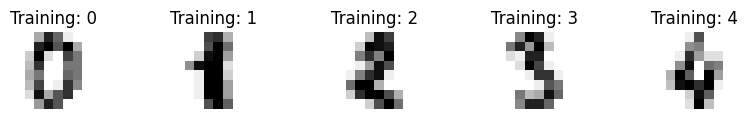

In [29]:
# load data
X, y = load_digits(return_X_y=True)

# plot
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 1))
for ax, img, target in zip(axes, X, y):
    ax.set_axis_off()
    ax.imshow(img.reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Training: {target}')

In [30]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test,
                                                    test_size = 0.5,
                                                    random_state = 42)

X_train.shape, X_valid.shape, X_test.shape

((1437, 64), (180, 64), (180, 64))

*Now, let's OHE the y data*

In [31]:
from sklearn.preprocessing import OneHotEncoder

# Fit an encoder
ohe_target = OneHotEncoder()
ohe_target.fit(y_train.reshape(-1, 1))

OneHotEncoder()

In [32]:
# Encode the target
y_train_ohe = ohe_target.transform(y_train.reshape(-1, 1)).toarray()
y_valid_ohe = ohe_target.transform(y_valid.reshape(-1, 1)).toarray()
y_test_ohe = ohe_target.transform(y_test.reshape(-1, 1)).toarray()

# validate
y_train[:5], y_train_ohe[:5]

(array([6, 0, 0, 3, 0]),
 array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

*Scale the data*

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_clean = scaler.transform(X_train)
X_valid_clean = scaler.transform(X_valid)
X_test_clean = scaler.transform(X_test)

In [34]:
# Transform data to torch.tensor format
Xs_train = torch.tensor(X_train_clean)
Xs_valid = torch.tensor(X_valid_clean)
Xs_test = torch.tensor(X_test_clean)

ys_train = torch.tensor(y_train_ohe)
ys_valid = torch.tensor(y_valid_ohe)
ys_test = torch.tensor(y_test_ohe)

## **Task 4**
---

- Perform Batch, Minibatch, and Stochastic Gradient Descent

*Create baseline model*

In [35]:
# Create object
mdl_baseline = DummyClassifier(strategy='most_frequent')

# Fit object
mdl_baseline.fit(Xs_train, y_train)

# Predict
y_train_pred = mdl_baseline.predict_proba(Xs_train)
y_valid_pred = mdl_baseline.predict_proba(Xs_valid)

# Convert result to torch tensor
ys_train_pred = torch.tensor(y_train_pred)
ys_valid_pred = torch.tensor(y_valid_pred)

# Show scores
bce_train_baseline = cross_entropy_loss(ys_train_pred, ys_train)
bce_valid_baseline = cross_entropy_loss(ys_valid_pred, ys_valid)

print('Baseline CEL score - Train :', bce_train_baseline.item())
print('Baseline CEL score - Valid :', bce_valid_baseline.item())

Baseline CEL score - Train : 32.89315712524827
Baseline CEL score - Valid : 33.77124803057934


*Great! Now let's create a Neural Network model*

*Batch modeling*

In [36]:
torch.manual_seed(123)

# Layer model
layers = [
    Linear(feature_in=64, feature_out=32, bias=True), Tanh(),
    Linear(feature_in=32, feature_out=10, bias=True), Softmax()
]

# Create the model
mdl_nn = Sequential(layers = layers)

# Activate the computational graph gradient
parameters = mdl_nn.parameters()
for p in parameters:
    p.requires_grad = True

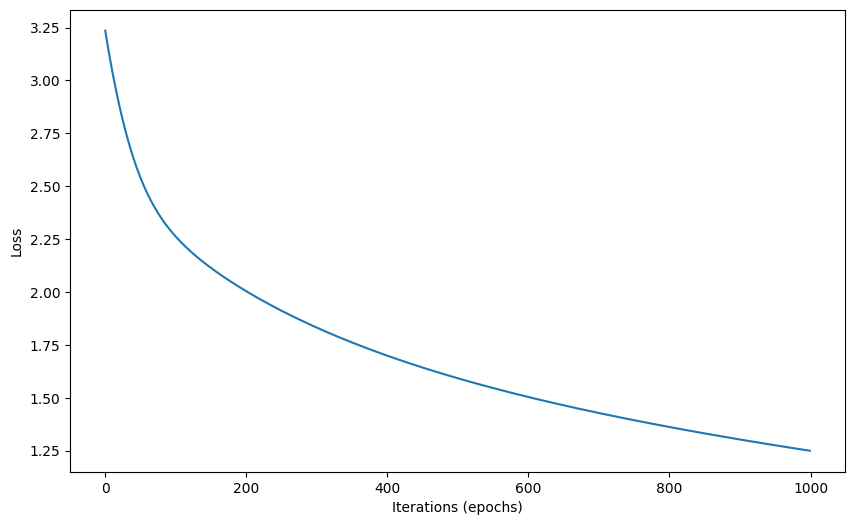

NN CEL score - Train : 1.249296556748998
NN CEL score - Valid : 1.155137498800989
Training time (s)    : 1.1674580574035645


In [37]:
# Now, let's perform the Gradient Descent
losses = []
iters = []

start_time = time.time()
for k in range(1_000):
    # Do the forward pass to get prediction & loss
    y_pred = mdl_nn(Xs_train)
    loss = cross_entropy_loss(input=y_pred, target=ys_train)

    # Do the backpropagation
    # Always reset the parameter gradient every iterations
    for p in parameters:
        p.grad = None

    # Then, do the backpropagation
    loss.backward()

    # Now, let's update the model
    for p in parameters:
        p.data += -0.01 * p.grad

    # Append
    losses.append(loss.item())
    iters.append(k)
end_time = time.time()

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.plot(iters, losses)
ax.set_xlabel('Iterations (epochs)')
ax.set_ylabel('Loss')
plt.show()

# Summarize
print('NN CEL score - Train :', cross_entropy_loss(input=mdl_nn(Xs_train), target=ys_train).item())
print('NN CEL score - Valid :', cross_entropy_loss(input=mdl_nn(Xs_valid), target=ys_valid).item())
print('Training time (s)    :', end_time - start_time)

*Predict the digit*

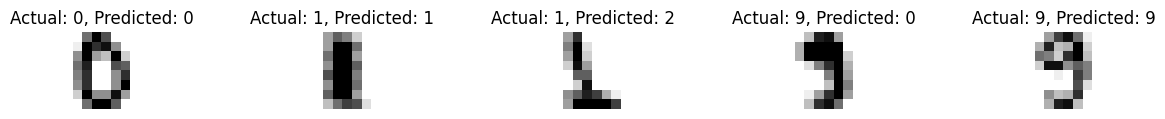

In [38]:
# Using the Batch GD
y_valid_pred = torch.argmax(mdl_nn(Xs_valid), axis=1)

# plot
ix = torch.randint(0, Xs_valid.shape[0], (5,))
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 1))
for ax, img, act, pred in zip(axes, X_valid[ix], y_valid[ix], y_valid_pred[ix]):
    ax.set_axis_off()
    ax.imshow(img.reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Actual: {act}, Predicted: {pred}')

*Mini-Batch modeling*

In [39]:
torch.manual_seed(123)

# Layer model
layers = [
    Linear(feature_in=64, feature_out=32, bias=True), Tanh(),
    Linear(feature_in=32, feature_out=10, bias=True), Softmax()
]

# Create the model
mdl_nn = Sequential(layers = layers)

# Activate the computational graph gradient
parameters = mdl_nn.parameters()
for p in parameters:
    p.requires_grad = True

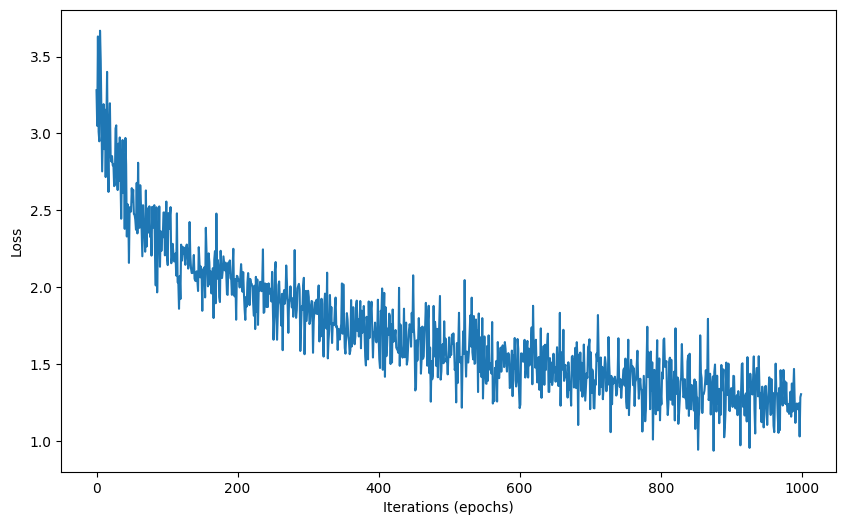

NN CEL score - Train : 1.2515523122499972
NN CEL score - Valid : 1.1511507081834838
Training time (s)    : 0.5443832874298096


In [40]:
torch.manual_seed(123)

# Now, let's perform the Gradient Descent
losses = []
iters = []

start_time = time.time()
for k in range(1_000):
    # Create a mini-batch
    # Take 32 samples every iteration
    ix = torch.randint(0, Xs_train.shape[0], (32,))

    # Filter data
    Xs_train_batch = Xs_train[ix]
    ys_train_batch = ys_train[ix]

    # Do the forward pass to get prediction & loss
    y_pred = mdl_nn(Xs_train_batch)
    loss = cross_entropy_loss(input=y_pred, target=ys_train_batch)

    # Do the backpropagation
    # Always reset the parameter gradient every iterations
    for p in parameters:
        p.grad = None

    # Then, do the backpropagation
    loss.backward()

    # Now, let's update the model
    for p in parameters:
        p.data += -0.01 * p.grad

    # Append
    losses.append(loss.item())
    iters.append(k)
end_time = time.time()

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.plot(iters, losses)
ax.set_xlabel('Iterations (epochs)')
ax.set_ylabel('Loss')
plt.show()

# Summarize
print('NN CEL score - Train :', cross_entropy_loss(input=mdl_nn(Xs_train), target=ys_train).item())
print('NN CEL score - Valid :', cross_entropy_loss(input=mdl_nn(Xs_valid), target=ys_valid).item())
print('Training time (s)    :', end_time - start_time)

*Predict the digit*

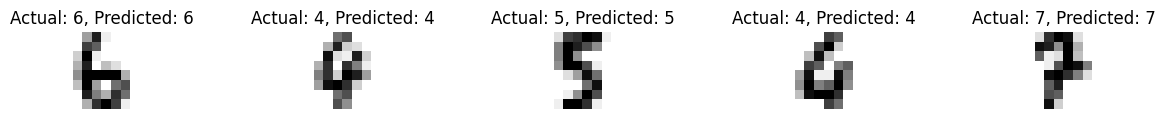

In [41]:
# Using the Mini-Batch GD
y_valid_pred = torch.argmax(mdl_nn(Xs_valid), axis=1)

# plot
ix = torch.randint(0, Xs_valid.shape[0], (5,))
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 1))
for ax, img, act, pred in zip(axes, X_valid[ix], y_valid[ix], y_valid_pred[ix]):
    ax.set_axis_off()
    ax.imshow(img.reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Actual: {act}, Predicted: {pred}')

*Stochastics modeling*

In [42]:
torch.manual_seed(123)

# Layer model
layers = [
    Linear(feature_in=64, feature_out=32, bias=True), Tanh(),
    Linear(feature_in=32, feature_out=10, bias=True), Softmax()
]

# Create the model
mdl_nn = Sequential(layers = layers)

# Activate the computational graph gradient
parameters = mdl_nn.parameters()
for p in parameters:
    p.requires_grad = True

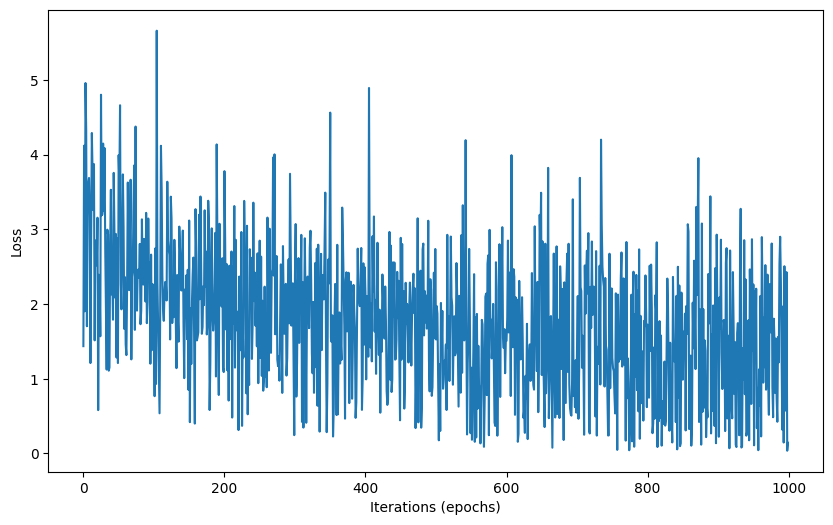

NN CEL score - Train : 1.2961527918180362
NN CEL score - Valid : 1.185971938552363
Training time (s)    : 0.4549746513366699


In [43]:
torch.manual_seed(123)

# Now, let's perform the Gradient Descent
losses = []
iters = []

start_time = time.time()
for k in range(1_000):
    # Create a stochastics
    # Take a sample every iteration
    ix = torch.randint(0, Xs_train.shape[0], (1,))

    # Filter data
    Xs_train_batch = Xs_train[ix]
    ys_train_batch = ys_train[ix]

    # Do the forward pass to get prediction & loss
    y_pred = mdl_nn(Xs_train_batch)
    loss = cross_entropy_loss(input=y_pred, target=ys_train_batch)

    # Do the backpropagation
    # Always reset the parameter gradient every iterations
    for p in parameters:
        p.grad = None

    # Then, do the backpropagation
    loss.backward()

    # Now, let's update the model
    for p in parameters:
        p.data += -0.01 * p.grad

    # Append
    losses.append(loss.item())
    iters.append(k)
end_time = time.time()

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.plot(iters, losses)
ax.set_xlabel('Iterations (epochs)')
ax.set_ylabel('Loss')
plt.show()

# Summarize
print('NN CEL score - Train :', cross_entropy_loss(input=mdl_nn(Xs_train), target=ys_train).item())
print('NN CEL score - Valid :', cross_entropy_loss(input=mdl_nn(Xs_valid), target=ys_valid).item())
print('Training time (s)    :', end_time - start_time)

*Predict the digit*

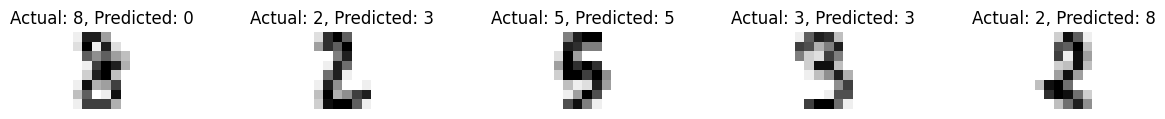

In [44]:
# Using the Stochastics GD
y_valid_pred = torch.argmax(mdl_nn(Xs_valid), axis=1)

# plot
ix = torch.randint(0, Xs_valid.shape[0], (5,))
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 1))
for ax, img, act, pred in zip(axes, X_valid[ix], y_valid[ix], y_valid_pred[ix]):
    ax.set_axis_off()
    ax.imshow(img.reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Actual: {act}, Predicted: {pred}')

Summarize
- At 1000 iterations (epochs) we get almost similar results.
- Model performance: Batch GD > mini batch GD > stochastics GD
- Time performance: Stochastics GD > mini batch GD > Batch GD
- Smoothness results performance: Batch GD > mini batch GD > stochastics GD

## **Task 5**
---

- Your task is to choose the proper learning rate for the current task.
- Use the LR Range test [(see ref)](https://brandonmorris.dev/2018/06/24/mastering-the-learning-rate/)

*Now, let's create a Neural Network on Mini-Batch*

*Small learning rate = 0.0001*

In [45]:
torch.manual_seed(123)

# Layer model
layers = [
    Linear(feature_in=64, feature_out=32, bias=True), Tanh(),
    Linear(feature_in=32, feature_out=10, bias=True), Softmax()
]

# Create the model
mdl_nn = Sequential(layers = layers)

# Activate the computational graph gradient
parameters = mdl_nn.parameters()
for p in parameters:
    p.requires_grad = True

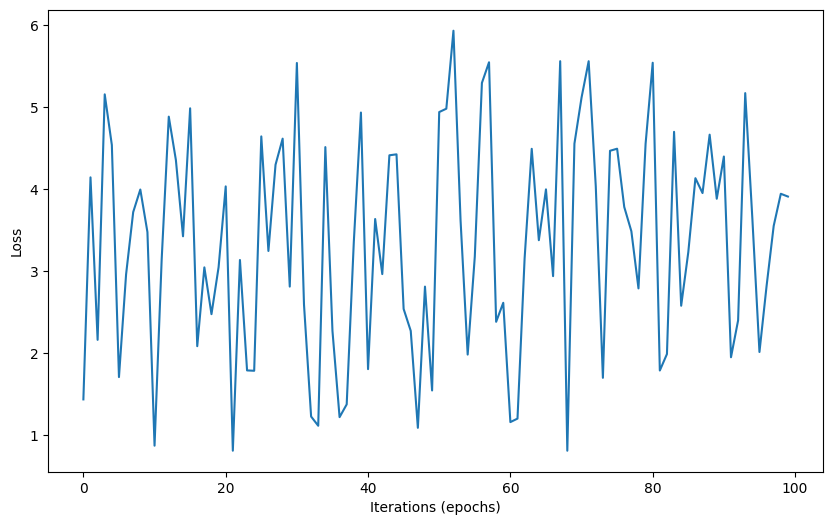

NN CEL score - Train : 3.2113914371864207
NN CEL score - Valid : 2.948680498998396
Training time (s)    : 0.04700040817260742


In [46]:
torch.manual_seed(123)

# Now, let's perform the Gradient Descent
losses = []
iters = []

start_time = time.time()
for k in range(100):
    # Create a mini-batch
    # Take 32 samples every iteration
    ix = torch.randint(0, Xs_train.shape[0], (1,))

    # Filter data
    Xs_train_batch = Xs_train[ix]
    ys_train_batch = ys_train[ix]

    # Do the forward pass to get prediction & loss
    y_pred = mdl_nn(Xs_train_batch)
    loss = cross_entropy_loss(input=y_pred, target=ys_train_batch)

    # Do the backpropagation
    # Always reset the parameter gradient every iterations
    for p in parameters:
        p.grad = None

    # Then, do the backpropagation
    loss.backward()

    # Now, let's update the model
    for p in parameters:
        p.data += -0.0001 * p.grad

    # Append
    losses.append(loss.item())
    iters.append(k)
end_time = time.time()

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.plot(iters, losses)
ax.set_xlabel('Iterations (epochs)')
ax.set_ylabel('Loss')
plt.show()

# Summarize
print('NN CEL score - Train :', cross_entropy_loss(input=mdl_nn(Xs_train), target=ys_train).item())
print('NN CEL score - Valid :', cross_entropy_loss(input=mdl_nn(Xs_valid), target=ys_valid).item())
print('Training time (s)    :', end_time - start_time)

*The loss decreases too slow*

*Now let's try a bigger ones, i.e. 1.0*

In [47]:
torch.manual_seed(123)

# Layer model
layers = [
    Linear(feature_in=64, feature_out=32, bias=True), Tanh(),
    Linear(feature_in=32, feature_out=10, bias=True), Softmax()
]

# Create the model
mdl_nn = Sequential(layers = layers)

# Activate the computational graph gradient
parameters = mdl_nn.parameters()
for p in parameters:
    p.requires_grad = True

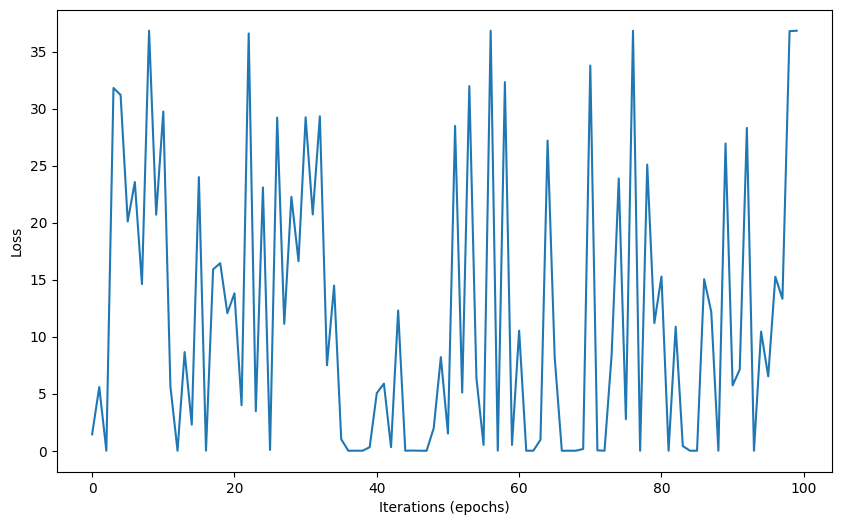

NN CEL score - Train : 12.815369290237212
NN CEL score - Valid : 10.915917780625778
Training time (s)    : 0.04621267318725586


In [48]:
torch.manual_seed(123)

# Now, let's perform the Gradient Descent
losses = []
iters = []

start_time = time.time()
for k in range(100):
    # Create a mini-batch
    # Take 32 samples every iteration
    ix = torch.randint(0, Xs_train.shape[0], (1,))

    # Filter data
    Xs_train_batch = Xs_train[ix]
    ys_train_batch = ys_train[ix]

    # Do the forward pass to get prediction & loss
    y_pred = mdl_nn(Xs_train_batch)
    loss = cross_entropy_loss(input=y_pred, target=ys_train_batch)

    # Do the backpropagation
    # Always reset the parameter gradient every iterations
    for p in parameters:
        p.grad = None

    # Then, do the backpropagation
    loss.backward()

    # Now, let's update the model
    for p in parameters:
        p.data += -1.0 * p.grad

    # Append
    losses.append(loss.item())
    iters.append(k)
end_time = time.time()

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.plot(iters, losses)
ax.set_xlabel('Iterations (epochs)')
ax.set_ylabel('Loss')
plt.show()

# Summarize
print('NN CEL score - Train :', cross_entropy_loss(input=mdl_nn(Xs_train), target=ys_train).item())
print('NN CEL score - Valid :', cross_entropy_loss(input=mdl_nn(Xs_valid), target=ys_valid).item())
print('Training time (s)    :', end_time - start_time)

- We can see that the losses range is blown up, i.e. larger than 30 (baseline)
- Also the losses are very fluctuative
- This is due to the high learning rate

*We got our learning rate boundary. Let's try to use learning rates between 0.0001 - 1.0*

In [49]:
torch.manual_seed(123)

# Layer model
layers = [
    Linear(feature_in=64, feature_out=32, bias=True), Tanh(),
    Linear(feature_in=32, feature_out=10, bias=True), Softmax()
]

# Create the model
mdl_nn = Sequential(layers = layers)

# Activate the computational graph gradient
parameters = mdl_nn.parameters()
for p in parameters:
    p.requires_grad = True

In [50]:
lre = torch.linspace(-4, 0, 1000)
lri = 10**lre

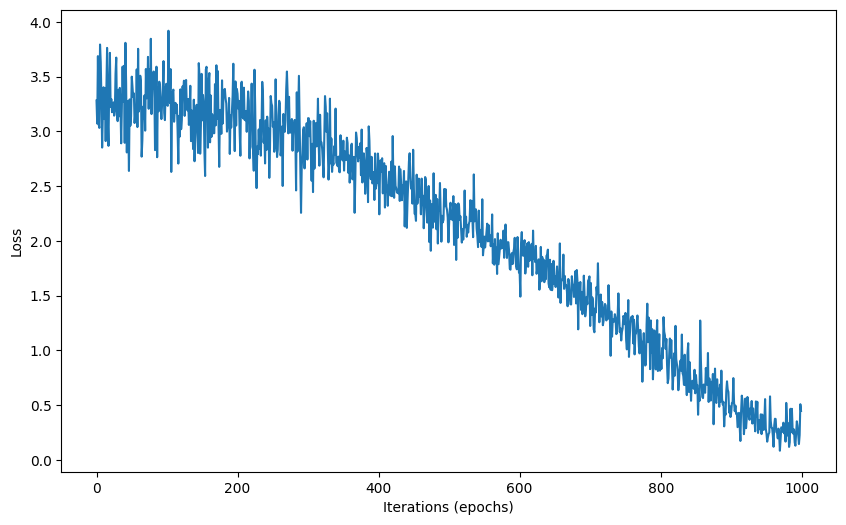

NN CEL score - Train : 0.2659178482550813
NN CEL score - Valid : 0.37273873350486264
Training time (s)    : 0.5374641418457031


In [51]:
torch.manual_seed(123)

# Now, let's perform the Gradient Descent
losses = []
iters = []

start_time = time.time()
for k in range(1_000):
    # Create a mini-batch
    # Take 32 samples every iteration
    ix = torch.randint(0, Xs_train.shape[0], (32,))

    # Filter data
    Xs_train_batch = Xs_train[ix]
    ys_train_batch = ys_train[ix]

    # Do the forward pass to get prediction & loss
    y_pred = mdl_nn(Xs_train_batch)
    loss = cross_entropy_loss(input=y_pred, target=ys_train_batch)

    # Do the backpropagation
    # Always reset the parameter gradient every iterations
    for p in parameters:
        p.grad = None

    # Then, do the backpropagation
    loss.backward()

    # Now, let's update the model
    lr_k = lri[k]
    for p in parameters:
        p.data += -lr_k * p.grad

    # Append
    losses.append(loss.item())
    iters.append(k)
end_time = time.time()

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.plot(iters, losses)
ax.set_xlabel('Iterations (epochs)')
ax.set_ylabel('Loss')
plt.show()

# Summarize
print('NN CEL score - Train :', cross_entropy_loss(input=mdl_nn(Xs_train), target=ys_train).item())
print('NN CEL score - Valid :', cross_entropy_loss(input=mdl_nn(Xs_valid), target=ys_valid).item())
print('Training time (s)    :', end_time - start_time)

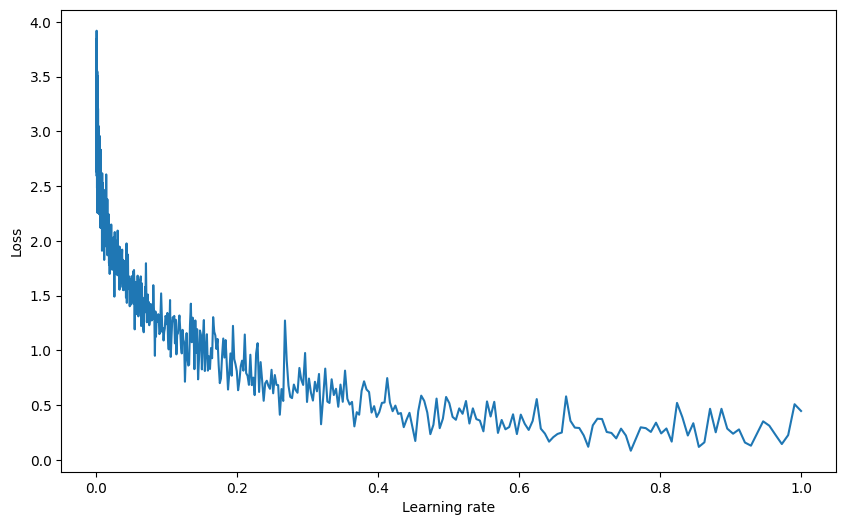

In [52]:
# Plot the effect of learning rate to loss
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.plot(lri, losses)
ax.set_xlabel('Learning rate')
ax.set_ylabel('Loss')
plt.show()

*We can set the optimum learning rate at $0.2$*

In [53]:
torch.manual_seed(123)

# Layer model
layers = [
    Linear(feature_in=64, feature_out=32, bias=True), Tanh(),
    Linear(feature_in=32, feature_out=10, bias=True), Softmax()
]

# Create the model
mdl_nn = Sequential(layers = layers)

# Activate the computational graph gradient
parameters = mdl_nn.parameters()
for p in parameters:
    p.requires_grad = True

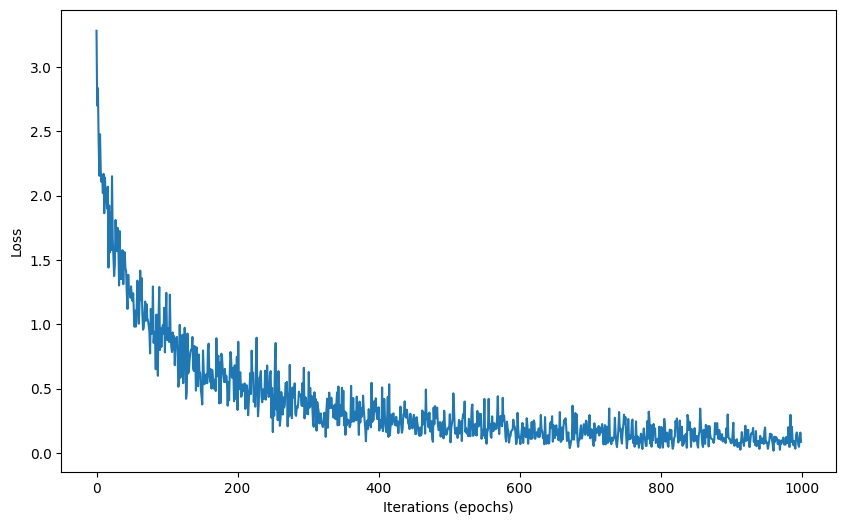

NN CEL score - Train : 0.10602268114402363
NN CEL score - Valid : 0.273371560254478
Training time (s)    : 0.5160865783691406


In [54]:
torch.manual_seed(123)

# Now, let's perform the Gradient Descent
losses = []
iters = []

start_time = time.time()
for k in range(1_000):
    # Create a mini-batch
    # Take 32 samples every iteration
    ix = torch.randint(0, Xs_train.shape[0], (32,))

    # Filter data
    Xs_train_batch = Xs_train[ix]
    ys_train_batch = ys_train[ix]

    # Do the forward pass to get prediction & loss
    y_pred = mdl_nn(Xs_train_batch)
    loss = cross_entropy_loss(input=y_pred, target=ys_train_batch)

    # Do the backpropagation
    # Always reset the parameter gradient every iterations
    for p in parameters:
        p.grad = None

    # Then, do the backpropagation
    loss.backward()

    # Now, let's update the model
    lr_k = 0.2
    for p in parameters:
        p.data += -lr_k * p.grad

    # Append
    losses.append(loss.item())
    iters.append(k)
end_time = time.time()

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.plot(iters, losses)
ax.set_xlabel('Iterations (epochs)')
ax.set_ylabel('Loss')
plt.show()

# Summarize
print('NN CEL score - Train :', cross_entropy_loss(input=mdl_nn(Xs_train), target=ys_train).item())
print('NN CEL score - Valid :', cross_entropy_loss(input=mdl_nn(Xs_valid), target=ys_valid).item())
print('Training time (s)    :', end_time - start_time)

*Predict the digit*

In [55]:
# Using the mini batch GD
y_test_pred = torch.argmax(mdl_nn(Xs_test), axis=1)

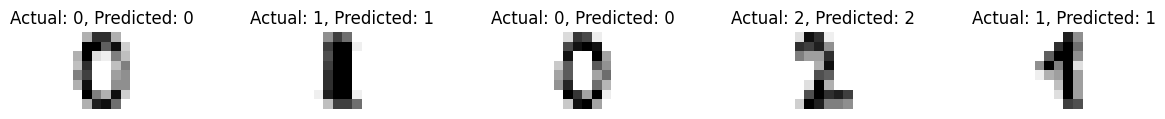

In [56]:
# plot
ix = torch.randint(0, Xs_valid.shape[0], (5,))
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 1))
for ax, img, act, pred in zip(axes, X_test[ix], y_test[ix], y_test_pred[ix]):
    ax.set_axis_off()
    ax.imshow(img.reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Actual: {act}, Predicted: {pred}')

## **Additional**
---

- Instead of using a sequential model, you can create an MLP class with `torch.nn` module

In [57]:
import torch.nn as nn
from torch.nn import functional as F

- Create an MLP class (see more practical code from [here](https://github.com/karpathy/makemore/blob/master/makemore.py))

In [58]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        # Initialize the MLP
        # We use similar architectures, i.e.
        # - 64 dim input
        # - 1 hidden layer (32)
        # - 1 output layer (10)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=64, out_features=32, bias=True), nn.Tanh(),
            nn.Linear(in_features=32, out_features=10, bias=True)
        )

    def forward(self, x, targets=None):
        """Do the feed forward"""
        # Find the logits (pre-activation function)
        x = x.to(torch.float32)
        logits = self.mlp(x)

        # Calculate the loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(input=logits, target=targets)

        return logits, loss


- Next, we initialize & train the model

In [59]:
# initialize model
model = MLP()
print(f'model #params: {sum(p.numel() for p in model.parameters())}')

# Initialize the optimizer (stochastic GD)
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.2)

# Training loop
torch.manual_seed(123)
step = 0
while True:
    t0 = time.time()

    # Create batch
    ix = torch.randint(0, Xs_train.shape[0], (32,))
    Xs_train_batch = Xs_train[ix]
    ys_train_batch = ys_train[ix]

    # feed into the model
    logits, loss = model.forward(Xs_train_batch, ys_train_batch)

    # Calculate the gradient, update the weights
    model.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    t1 = time.time()

    # Logging
    if step % 100 == 0:
        print(f'step {step} | loss {loss.item():.4f} | step time {(t1-t0)*1000:.2f}ms')

    # Termination conditions
    step += 1
    if step >= 1000:
        print(f'step {step} | loss {loss.item():.4f} | step time {(t1-t0)*1000:.2f}ms')
        break

model #params: 2410
step 0 | loss 2.4304 | step time 1.32ms
step 100 | loss 0.3341 | step time 0.56ms
step 200 | loss 0.0526 | step time 0.57ms
step 300 | loss 0.0345 | step time 0.54ms
step 400 | loss 0.0568 | step time 0.54ms
step 500 | loss 0.0569 | step time 0.77ms
step 600 | loss 0.0284 | step time 0.54ms
step 700 | loss 0.0099 | step time 0.55ms
step 800 | loss 0.0191 | step time 0.60ms
step 900 | loss 0.0397 | step time 0.53ms
step 1000 | loss 0.0141 | step time 0.54ms


*Predict the digit*

In [60]:
# Using the mini batch GD
y_test_pred = torch.argmax(model.forward(Xs_test)[0].data, axis=1)

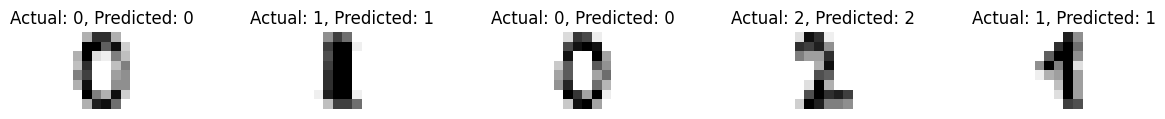

In [61]:
# plot
ix = torch.randint(0, Xs_valid.shape[0], (5,))
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 1))
for ax, img, act, pred in zip(axes, X_test[ix], y_test[ix], y_test_pred[ix]):
    ax.set_axis_off()
    ax.imshow(img.reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Actual: {act}, Predicted: {pred}')